# Resume Parsing

In [1]:
# !pip3 install PyPDF2

In [2]:
import PyPDF2
PyPDF2.__version__

'3.0.1'

## 1. Load data

In [3]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("data/resume.csv")

In [4]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [5]:
df_resume.shape

(2484, 4)

In [6]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [7]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path = 'data/skills.jsonl'

In [8]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [9]:
doc = nlp("Chaky loves ajax.")
doc.ents

(Chaky, ajax)

## 3. Let's try to extract skills from this resume.csv

In [10]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
180,20748926,JEWELRY DESIGNER AND OWNER Summ...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER
80,25724495,REGIONAL HR MANAGER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",HR
1091,24610685,SALES ENGINEER Summary I...,"<div class=""fontsize fontface vmargins hmargin...",SALES
243,13385306,DIRECTOR OF INFORMATION TECHNOLOGY ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
783,25834360,FIELD NURSE Professional Su...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE


In [11]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [12]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         CONSULTANT           Highlights        TECHNOLOGY SKILLS Visual Basic * HTML * JavaScript * SQL * XML * Python * MVC * FileMaker * PHP * Advanced Excel * SiteCatalyst CORE COMPETENCIES Problem Solving * Relational Databases * Process Reengineering * Customer Relations * Staff Management Sta'

In [13]:
preprocessing(random_resume[:300])

'consultant highlight technology skills visual basic * html javascript sql xml python mvc filemaker php advanced excel sitecatalyst core competencies problem solving relational database * process reengineering customer relations staff management sta'

In [14]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [15]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
180,20748926,JEWELRY DESIGNER AND OWNER Summ...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,jewelry designer and owner summary skillful de...
80,25724495,REGIONAL HR MANAGER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",HR,regional hr manager summary holistic hr profes...
1091,24610685,SALES ENGINEER Summary I...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale engineer summary i currently look advance...
243,13385306,DIRECTOR OF INFORMATION TECHNOLOGY ...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,director of information technology profile sum...
783,25834360,FIELD NURSE Professional Su...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE,field nurse professional summary california li...


## 4. Let's really extract skills!!

In [16]:
def get_skills(text):
    
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
            
    return skills

def unique_skills(x):
    return list(set(x))

In [17]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [18]:
df_resume.Skills.iloc[0]

['interaction',
 'database',
 'accounting',
 'material',
 'telephony',
 'business',
 'box',
 'security',
 'support',
 'schedule',
 'software',
 'medium',
 'advertising']

## 5. Visualization

Which skills is most important in information management?

In [19]:
# set(df_resume.Category)

In [20]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(38, 6)

In [21]:
all_skills = np.concatenate(df_resume_it.Skills.values)

In [22]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))

In [23]:
counting

OrderedDict([('support', 35),
             ('software', 32),
             ('business', 27),
             ('database', 24),
             ('security', 24),
             ('windows', 22),
             ('server', 21),
             ('design', 21),
             ('project management', 17),
             ('documentation', 16)])

<BarContainer object of 10 artists>

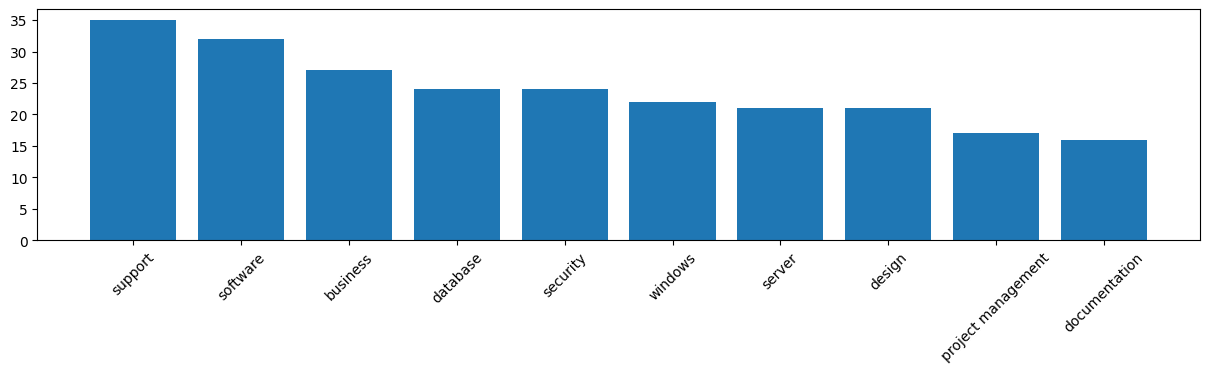

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation=45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [25]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[32]

In [26]:
doc = nlp(text)

In [27]:
# colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
# options = {"colors": colors}

# displacy.render(doc, style='ent', options=options)

## 7. Let's load the PDF - add some realism

In [28]:
from PyPDF2 import PdfReader

reader = PdfReader("data/chaklam_resume.pdf")
page = reader.pages[0]
text = page.extract_text()

In [29]:
text = preprocessing(text)

In [30]:
doc = nlp(text)

In [31]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)